# Dataset and CNNs Loading

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torchvision.models.resnet import resnet34,resnet50,resnet101
from torchvision.models.densenet import densenet121,densenet169,densenet201
from torchvision.models.vgg import vgg11_bn,vgg16_bn,vgg19_bn
from torchvision.transforms.transforms import Resize
import pickle

transform = transforms.Compose([
transforms.Resize(128),  # Resolution [64,128,224] can be set to compare different performance 
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # normlization for CIFAR100
])
batch_size=128 # batch size [32 ,64,128,512]  can be set to compare different performance 

# data loader
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
 
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

net = models.resnet34(pretrained=True) # use pretrained weights for training

# we can use the net_list to loop all the model in the list of models
# in this project, we run the model one by one, because runing all models in a time 
# may face interupting problems.
net_list = [vgg11_bn(pretrained=True), vgg16_bn(pretrained=True),vgg19_bn(pretrained=True),
            resnet34(pretrained=True), resnet50(pretrained=True),resnet101(pretrained=True),
            densenet121(pretrained=True), densenet169(pretrained=True),densenet201(pretrained=True)]

for param in net.parameters(): #the parameters of net can be updated
    param.requires_grad = True

# suitable for ResNet 
fc_inputs = net.fc.in_features  # get the input features
net.fc = nn.Sequential(         # redefine the feature layer, based on the needed number of classification
    nn.Linear(fc_inputs, 100),  # we can custom the feature layer by self
    nn.LogSoftmax(dim=1)
)

# # suitable for VGG 
# net.classifier = nn.Sequential(        
#     nn.Linear(in_features=25088, out_features=4096, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=4096, out_features=4096, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=4096, out_features=100, bias=True),
#     nn.LogSoftmax(dim=1)
# )

# # suitable for DenseNet 
# fc_inputs = net.classifier.in_features
# net.classifier = nn.Sequential(         
#     nn.Linear(fc_inputs, 100),  
#     nn.LogSoftmax(dim=1)
# )


Files already downloaded and verified
Files already downloaded and verified


# The blocks of VGG, ResNet and DenseNet 

In [7]:
# VGG block
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 3
    # the part of the convolution
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # the part of full connection
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 100))

#net = vgg(conv_arch)

In [8]:
# ResNet block

class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
# blk = Residual(3,3)
# X = torch.rand(4, 3, 6, 6)
# Y = blk(X)
# Y.shape

# blk = Residual(3,6, use_1x1conv=True, strides=2)
# blk(X).shape


In [9]:
# DenseNet block

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
    
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1) #concat the feature matrix
        return X
# blk = DenseBlock(2, 3, 10)
# X = torch.randn(4, 3, 8, 8)
# Y = blk(X)
# Y.shape
    
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))
    
# blk = transition_block(23, 10)
# blk(Y).shape

b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# num_channels are the current channal number 
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # Number of output channels of the previous DenseBlock 
    num_channels += num_convs * growth_rate
    # Adding a transition_block layer between dense blocks halves the number of channels
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2
        
# net = nn.Sequential(
#     b1, *blks,
#     nn.BatchNorm2d(num_channels), nn.ReLU(),
#     nn.AdaptiveAvgPool2d((1, 1)),
#     nn.Flatten(),
#     nn.Linear(num_channels, 10))

# Hyperparameters setting and model training and testing

In [11]:
# for i in net_list: # if need loop the all the models in one time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# adjust parameters for lr of optimizer
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12, 20], gamma=0.1)

n_epochs = 20

# record loss and accuracy in each epoch
train_loss_lst = []
train_acc_lst = []
test_loss_lst = []
test_acc_lst = []

for epoch in range(n_epochs):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(torch.squeeze(inputs, 1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 80 == 79:
            print(batch_idx+1,'/', len(trainloader),'epoch: %d' % epoch, 
                'lr: %.5f' % optimizer.param_groups[0]['lr'], 
                '| train Loss: %.3f | train Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_loss_lst.append(train_loss/(batch_idx+1))
    train_acc_lst.append(correct/total)

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(torch.squeeze(inputs, 1))
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx == len(testloader)-1:
                print(batch_idx,'/',len(testloader),'epoch: %d'% epoch, 'test Loss: %.3f | test Acc: %.3f%% (%d/%d)'
                    % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    test_loss_lst.append(test_loss/(batch_idx+1))
    test_acc_lst.append(correct/total)
    scheduler.step()
    
data_to_save = [train_loss_lst,
                train_acc_lst,
                test_loss_lst,
                test_acc_lst]  


# # when loop all models, the filename can be automatically change by f'{netname[0]}' etc.
# with open('resnet34cifar100-alllayers-metrics.pkl', 'wb') as file:
#     pickle.dump(data_to_save, file)

# torch.save(net.state_dict(),'resnet101cifar34-alllayers.pkl')
# print('over test')
 
# #Reloaad the trained model
# net.load_state_dict(torch.load('resnet101cifar100.pkl')) 
# mydict=net.state_dict()
# for k,v in mydict.items():    
#    print('k===',k,'||||,v==',v)
 
# models=net.modules()
# for p in models:
#     if p._get_name()!='Linear':
#         print(p._get_name())



80 / 391 epoch: 0 lr: 0.01000 | train Loss: 0.659 | train Acc: 80.312% (8224/10240)
160 / 391 epoch: 0 lr: 0.01000 | train Loss: 0.667 | train Acc: 79.590% (16300/20480)
240 / 391 epoch: 0 lr: 0.01000 | train Loss: 0.689 | train Acc: 79.062% (24288/30720)
320 / 391 epoch: 0 lr: 0.01000 | train Loss: 0.695 | train Acc: 78.855% (32299/40960)
78 / 79 epoch: 0 test Loss: 0.914 | test Acc: 73.430% (7343/10000)
80 / 391 epoch: 1 lr: 0.01000 | train Loss: 0.338 | train Acc: 89.502% (9165/10240)
160 / 391 epoch: 1 lr: 0.01000 | train Loss: 0.332 | train Acc: 89.600% (18350/20480)
240 / 391 epoch: 1 lr: 0.01000 | train Loss: 0.341 | train Acc: 89.157% (27389/30720)
320 / 391 epoch: 1 lr: 0.01000 | train Loss: 0.350 | train Acc: 88.784% (36366/40960)
78 / 79 epoch: 1 test Loss: 0.937 | test Acc: 74.310% (7431/10000)
80 / 391 epoch: 2 lr: 0.01000 | train Loss: 0.196 | train Acc: 93.809% (9606/10240)
160 / 391 epoch: 2 lr: 0.01000 | train Loss: 0.184 | train Acc: 94.326% (19318/20480)
240 / 391 ep

# Plot Learning Curve

In [12]:
import matplotlib.pyplot as plt
def learn_curve(n_epochs,loss_lst,accuracy_lst,test_loss,accuracy_test_lst, model_number = "ResNet34",title = f'CNN'):
    epochs = range(n_epochs)
    plt.figure(figsize=(10, 6))
    max_loss = max(loss_lst)
    normalization = [loss / max_loss for loss in loss_lst]
    normalization_test = [loss / max_loss for loss in test_loss]
    plt.plot(epochs, normalization, label='Train Loss(normalization)', marker='o', markersize=3)
    plt.plot(epochs, accuracy_lst, label='Train Accuracy', marker='s', markersize=3)
    plt.plot(epochs,normalization_test, label='Test Loss(normalization)', marker='x', markersize=3)
    plt.plot(epochs,accuracy_test_lst, label='Test Accuracy', marker='x', markersize=3)

    plt.title(f"{title}-{model_number}")
    plt.xlabel('Epochs')
    plt.ylabel('Value')

    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def learn_curve_loss_or_acc(n_epochs,loss_lst34,test_loss34,loss_lst50,test_loss50,
                            loss_lst101,test_loss101, type = "Loss",
                            model_number = "Train and Test Loss Curve",
                            title = ['ResNet34', 'ResNet50', 'ResNet101']):
    epochs = range(n_epochs)
    plt.figure(figsize=(10, 6))
    # max_loss = max(loss_lst)
    loss34 = [loss  for loss in loss_lst34]
    loss34_test = [loss for loss in test_loss34]
    loss50 = [loss  for loss in loss_lst50]
    loss50_test = [loss for loss in test_loss50]
    loss101 = [loss  for loss in loss_lst101]
    loss101_test = [loss for loss in test_loss101]
    
    plt.plot(epochs, loss34, label=f'{title[0]} Train {type}', color='red', marker='o', markersize=3)
    plt.plot(epochs, loss34_test, label=f'{title[0]} Test {type}', color='red',marker='o', linestyle='--',markersize=3)
    
    plt.plot(epochs,loss50, label=f'{title[1]} Train {type}',color='blue', marker='x', markersize=3)
    plt.plot(epochs,loss50_test, label=f'{title[1]} Test {type}', color='blue',marker='x',linestyle='--', markersize=3)
    
    plt.plot(epochs, loss101, label=f'{title[2]} Train {type}',color='green',marker='s', markersize=3)
    plt.plot(epochs, loss101_test, label=f'{title[2]} Test {type}',color='green', marker='s', linestyle='--',markersize=3)

    plt.title(f"{model_number}-{title[0]},{title[1]},{title[2]}")
    plt.xlabel('Epochs')
    plt.ylabel('Value')

    plt.legend()
    plt.grid(True)
    plt.show()
    

# Different Roselution

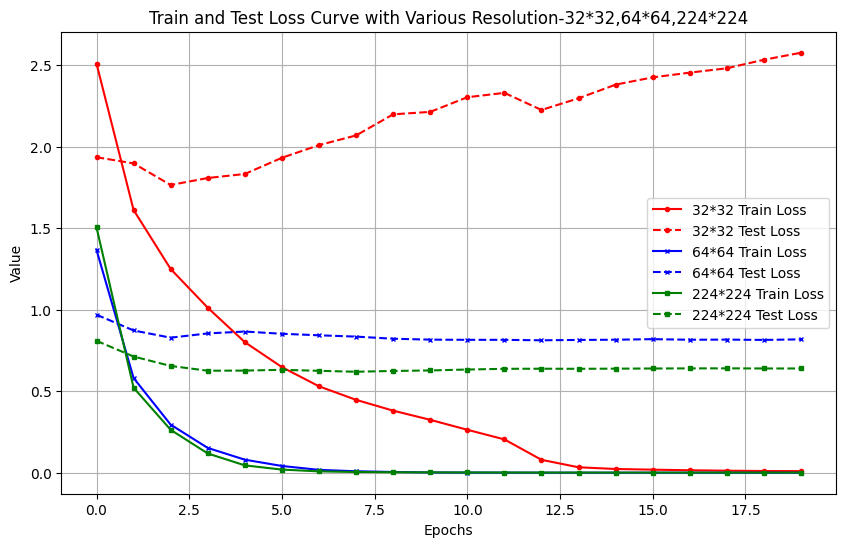

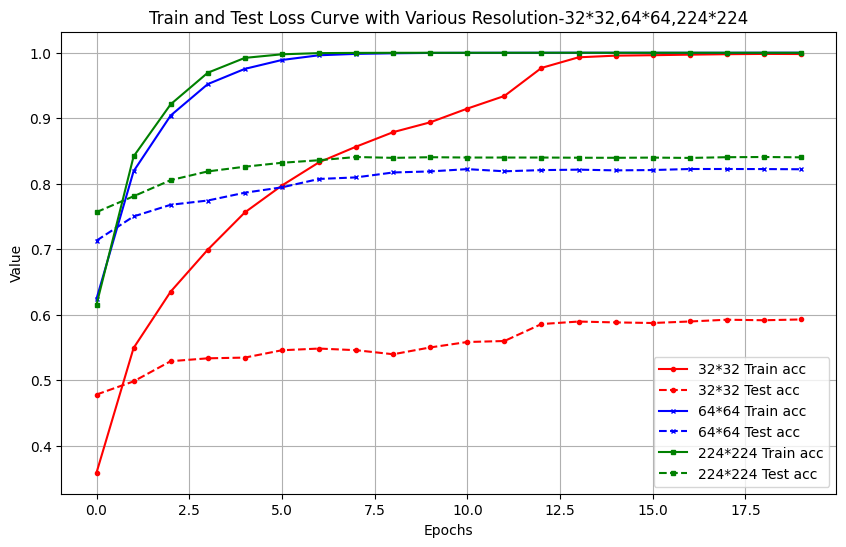

In [13]:
import matplotlib.pyplot as plt
import pickle


with open('resnet34cifar100-alllayers32-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss32, loaded_train_acc32, loaded_test_loss32, loaded_test_acc32 = loaded_data 

with open('resnet34cifar100-alllayers64-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss64, loaded_train_acc64, loaded_test_loss64, loaded_test_acc64 = loaded_data

with open('resnet34cifar100-alllayers-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss224, loaded_train_acc224, loaded_test_loss224, loaded_test_acc224 = loaded_data  

n_epochs =20
learn_curve_loss_or_acc(n_epochs,loaded_train_loss32, loaded_test_loss32,
                    loaded_train_loss64, loaded_test_loss64,
                    loaded_train_loss224, loaded_test_loss224,
                    type = "Loss",
                    model_number = "Train and Test Loss Curve with Various Resolution",
                    title = ['32*32', '64*64', '224*224'])

learn_curve_loss_or_acc(n_epochs,loaded_train_acc32, loaded_test_acc32,
                    loaded_train_acc64, loaded_test_acc64,
                    loaded_train_acc224, loaded_test_acc224,
                    type = "acc",
                    model_number = "Train and Test Loss Curve with Various Resolution",
                    title = ['32*32', '64*64', '224*224'])

# Different Batch Size

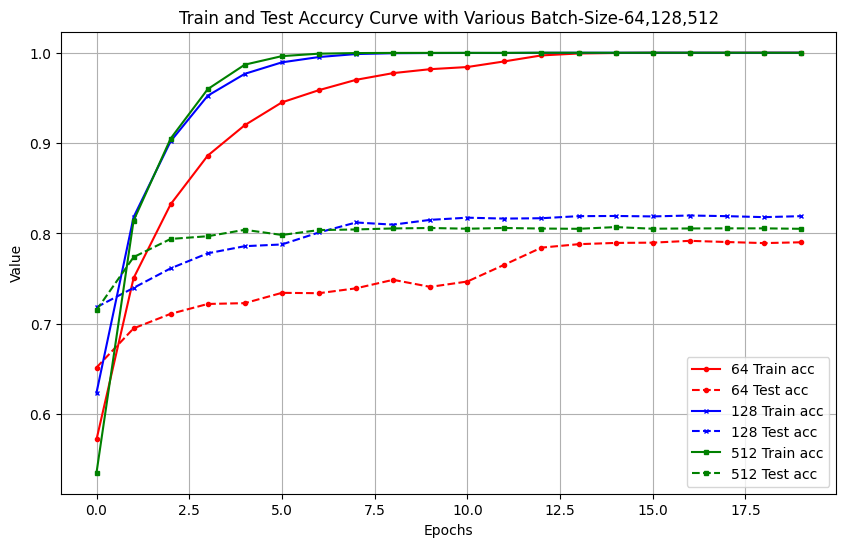

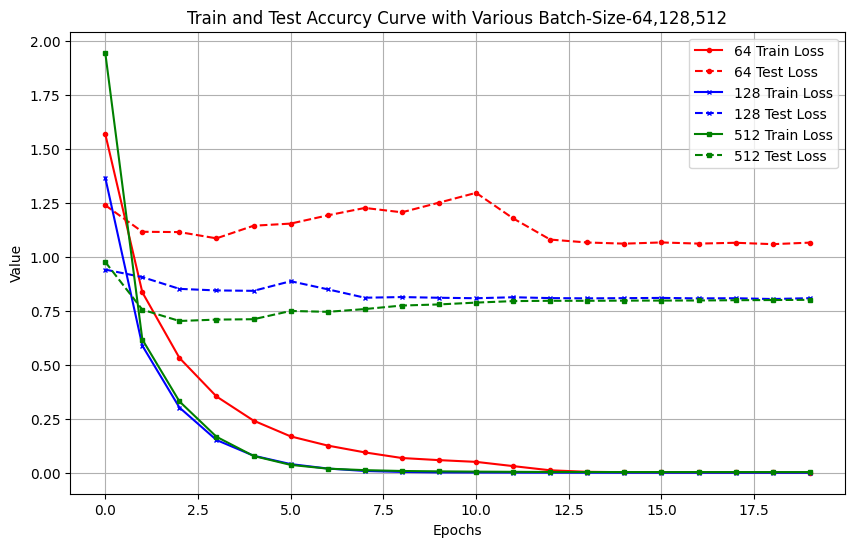

In [14]:
with open('resnet34cifar100-bs64-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss32, loaded_train_acc32, loaded_test_loss32, loaded_test_acc32 = loaded_data 

with open('resnet34cifar100-bs128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss64, loaded_train_acc64, loaded_test_loss64, loaded_test_acc64 = loaded_data

with open('resnet34cifar100-bs512-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss224, loaded_train_acc224, loaded_test_loss224, loaded_test_acc224 = loaded_data  

learn_curve_loss_or_acc(n_epochs,loaded_train_acc32, loaded_test_acc32,
                    loaded_train_acc64, loaded_test_acc64,
                    loaded_train_acc224, loaded_test_acc224,
                    type = "acc",
                    model_number = "Train and Test Accurcy Curve with Various Batch-Size",
                    title= ['64','128','512'])

learn_curve_loss_or_acc(n_epochs,loaded_train_loss32, loaded_test_loss32,
                    loaded_train_loss64, loaded_test_loss64,
                    loaded_train_loss224, loaded_test_loss224,
                    type = "Loss",
                    model_number = "Train and Test Accurcy Curve with Various Batch-Size",
                    title= ['64','128','512'])

# Different Resnet

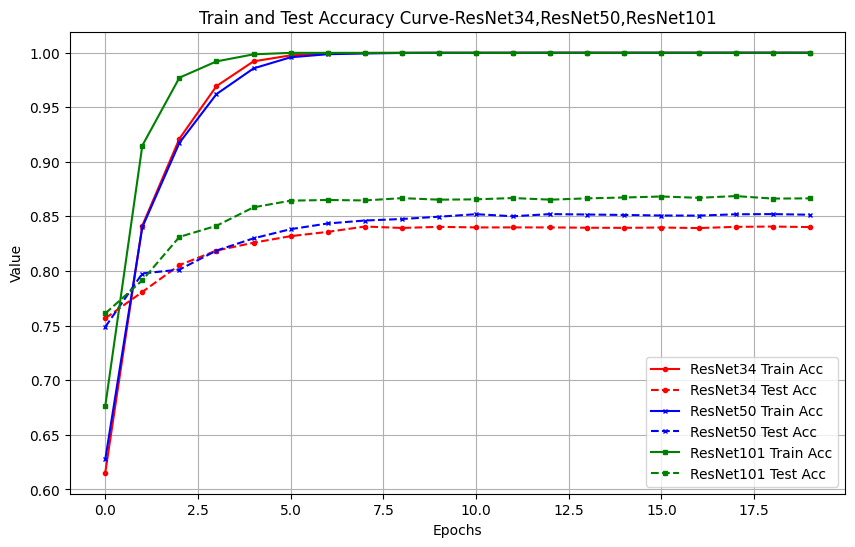

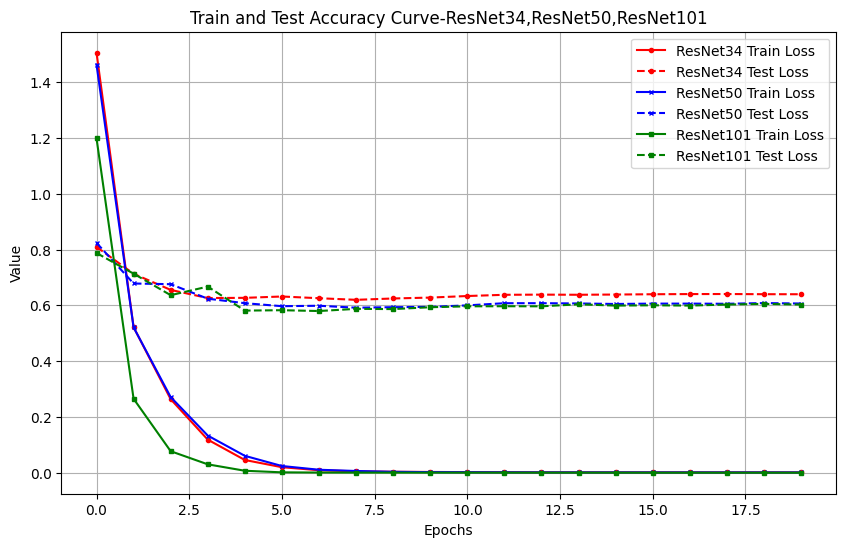

In [15]:

with open('resnet34cifar100-alllayers-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss34, loaded_train_acc34, loaded_test_loss34, loaded_test_acc34 = loaded_data

with open('resnet50cifar100-alllayers-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss50, loaded_train_acc50, loaded_test_loss50, loaded_test_acc50 = loaded_data

with open('resnet101cifar100-alllayers-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss101, loaded_train_acc101, loaded_test_loss101, loaded_test_acc101 = loaded_data
len(loaded_train_loss34),len(loaded_train_loss50),len(loaded_train_loss101)

learn_curve_loss_or_acc(n_epochs,loaded_train_acc34, loaded_test_acc34,
                     loaded_train_acc50, loaded_test_acc50,
                     loaded_train_acc101[::2], loaded_test_acc101[::2],
                     type = "Acc",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['ResNet34', 'ResNet50', 'ResNet101'])

learn_curve_loss_or_acc(n_epochs,loaded_train_loss34, loaded_test_loss34,
                     loaded_train_loss50, loaded_test_loss50,
                     loaded_train_loss101[::2], loaded_test_loss101[::2],
                     type = "Loss",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['ResNet34', 'ResNet50', 'ResNet101'])

# Different VGG

[1.251304194142547, 1.087130680114408, 0.9448967025249819, 1.0437067173704315, 1.0358369274984431, 1.1182352387452428, 1.2420490595358837, 1.2321297722526743, 1.2732021122039119, 1.340615659574919, 1.2570914980731434, 1.29897319666947, 1.12349834698665, 1.1263169359557237, 1.1388513792919208, 1.1393447729605664, 1.1484927497332609, 1.154979126362861, 1.1575216364256944, 1.1676568856722191]
[0.6378, 0.6829, 0.7297, 0.7222, 0.7414, 0.7329, 0.7294, 0.7362, 0.7478, 0.734, 0.7505, 0.7483, 0.7775, 0.7819, 0.7819, 0.7844, 0.7841, 0.7845, 0.7848, 0.788]
[1.1093086366412006, 0.9746333149415028, 0.9133386272418348, 1.0174592378773266, 0.9840037121048456, 1.0635867518714712, 1.1000621643247483, 1.067062565797492, 1.0927795367904856, 1.1265611920175673, 1.2243810612944108, 1.1637932190412208, 1.2172420190859445, 1.0116208527661577, 1.0228218240073965, 1.0209538815896722, 1.0319369533393956, 1.0346104612078848, 1.0476978164684922, 1.0552769646614413]
[0.6743, 0.7167, 0.7404, 0.7367, 0.7561, 0.7563,

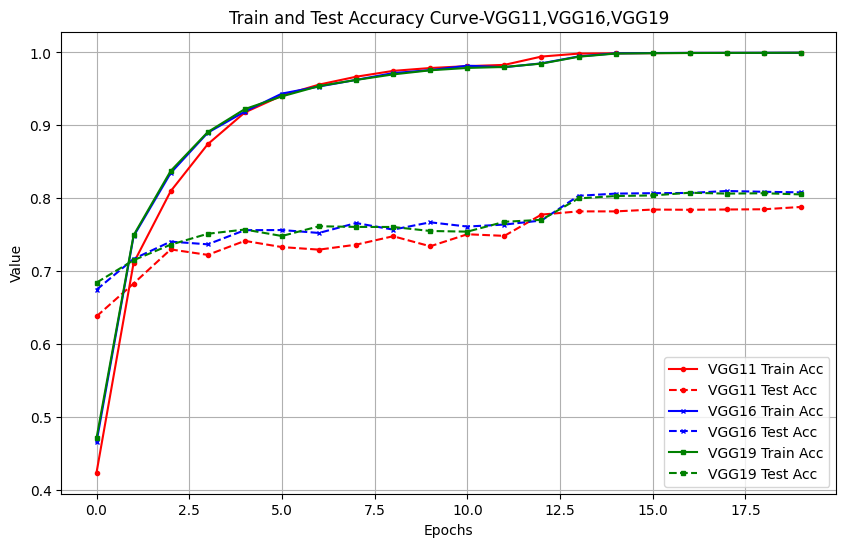

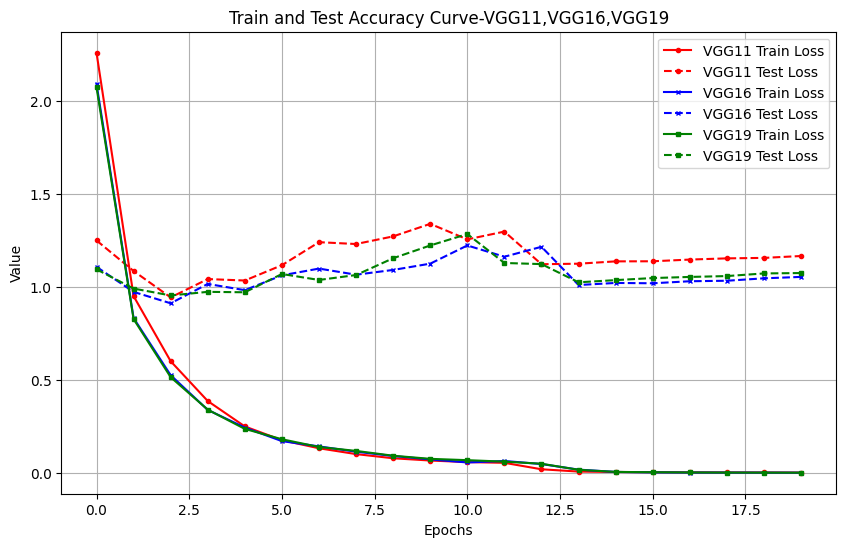

In [16]:
with open('vgg11cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss34, loaded_train_acc34, loaded_test_loss34, loaded_test_acc34 = loaded_data

with open('vgg16cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss50, loaded_train_acc50, loaded_test_loss50, loaded_test_acc50 = loaded_data

with open('vgg19cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss101, loaded_train_acc101, loaded_test_loss101, loaded_test_acc101 = loaded_data

print(loaded_test_loss34)
print(loaded_test_acc34) 

print(loaded_test_loss50)
print(loaded_test_acc50) 

print(loaded_test_loss101)
print(loaded_test_acc101) 

learn_curve_loss_or_acc(n_epochs,loaded_train_acc34, loaded_test_acc34,
                     loaded_train_acc50, loaded_test_acc50,
                     loaded_train_acc101, loaded_test_acc101,
                     type = "Acc",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['VGG11', 'VGG16', 'VGG19'])

learn_curve_loss_or_acc(n_epochs,loaded_train_loss34, loaded_test_loss34,
                     loaded_train_loss50, loaded_test_loss50,
                     loaded_train_loss101, loaded_test_loss101,
                     type = "Loss",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['VGG11', 'VGG16', 'VGG19'])

# Different DenseNet

[0.851379054633877, 0.825552908680107, 0.7283305620090871, 0.7205040458636948, 0.761751277160041, 0.7855693260325661, 0.7292467887643017, 0.711176558763166, 0.6998189133179339, 0.7023951365977903, 0.7049330438994155, 0.7012594217741037, 0.7042224837254875, 0.7000375510771063, 0.7032865466950815, 0.6997868856297264, 0.7014502200144755, 0.6992729785321634, 0.7031591734554195, 0.7011670266525655]
[0.7383, 0.7559, 0.7853, 0.7966, 0.8032, 0.8027, 0.8144, 0.8287, 0.8307, 0.8335, 0.8372, 0.8385, 0.8388, 0.8392, 0.8402, 0.8394, 0.8388, 0.8393, 0.8412, 0.8399]
[0.8215303277667565, 0.7570257458505751, 0.7081884538071065, 0.7138477865653702, 0.6809359732307966, 0.68310709542866, 0.6996577374542816, 0.6681310417531412, 0.667995312545873, 0.6815881197211109, 0.6712772763228114, 0.6703523084332671, 0.6744763255119324, 0.6758299054978769, 0.679152455888217, 0.6782833447184744, 0.6742599206634715, 0.6753150239775453, 0.676096423140055, 0.6778598046755488]
[0.7517, 0.773, 0.7955, 0.8056, 0.8234, 0.8312

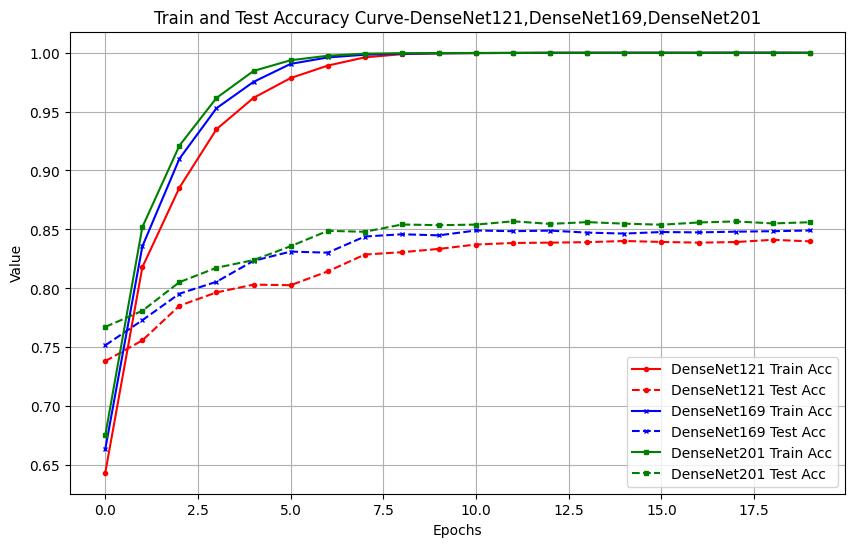

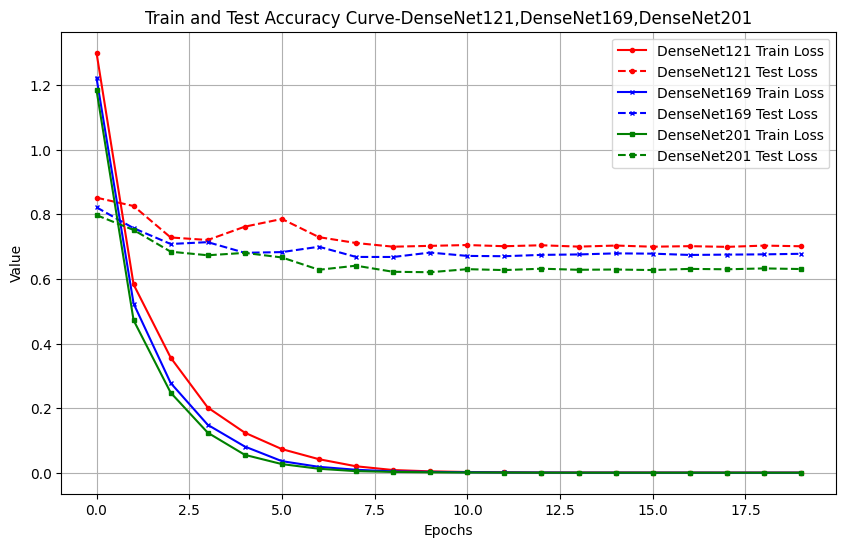

In [17]:
with open('densenet121cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss34, loaded_train_acc34, loaded_test_loss34, loaded_test_acc34 = loaded_data

with open('densenet169cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss50, loaded_train_acc50, loaded_test_loss50, loaded_test_acc50 = loaded_data

with open('densenet201cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss101, loaded_train_acc101, loaded_test_loss101, loaded_test_acc101 = loaded_data

print(loaded_test_loss34)
print(loaded_test_acc34) 

print(loaded_test_loss50)
print(loaded_test_acc50) 

print(loaded_test_loss101)
print(loaded_test_acc101) 

learn_curve_loss_or_acc(n_epochs,loaded_train_acc34, loaded_test_acc34,
                     loaded_train_acc50, loaded_test_acc50,
                     loaded_train_acc101, loaded_test_acc101,
                     type = "Acc",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['DenseNet121', 'DenseNet169', 'DenseNet201'])

learn_curve_loss_or_acc(n_epochs,loaded_train_loss34, loaded_test_loss34,
                     loaded_train_loss50, loaded_test_loss50,
                     loaded_train_loss101, loaded_test_loss101,
                     type = "Loss",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['DenseNet121', 'DenseNet169', 'DenseNet201'])

# Performance Comparison of VGG, ResNet and DenseNet

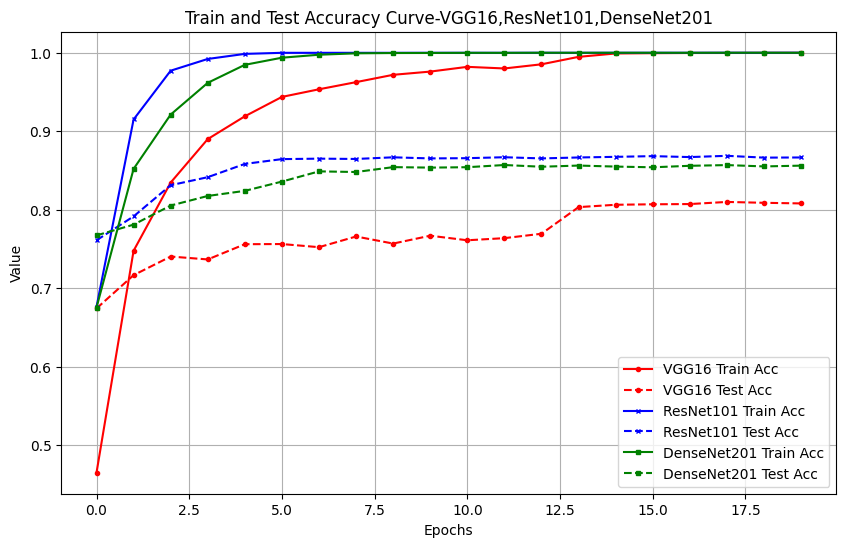

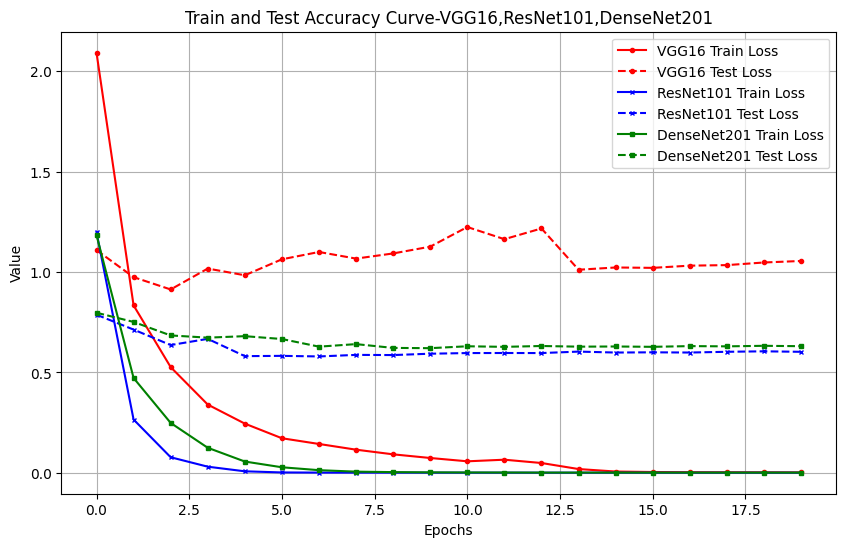

In [18]:
with open('vgg16cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
loaded_train_loss34, loaded_train_acc34, loaded_test_loss34, loaded_test_acc34 = loaded_data

with open('resnet101cifar100-alllayers-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss50, loaded_train_acc50, loaded_test_loss50, loaded_test_acc50 = loaded_data

with open('densenet201cifar100-alllayers128-metrics.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

loaded_train_loss101, loaded_train_acc101, loaded_test_loss101, loaded_test_acc101 = loaded_data

learn_curve_loss_or_acc(n_epochs,loaded_train_acc34, loaded_test_acc34,
                     loaded_train_acc50[::2], loaded_test_acc50[::2],
                     loaded_train_acc101, loaded_test_acc101,
                     type = "Acc",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['VGG16', 'ResNet101', 'DenseNet201'])

learn_curve_loss_or_acc(n_epochs,loaded_train_loss34, loaded_test_loss34,
                     loaded_train_loss50[::2], loaded_test_loss50[::2],
                     loaded_train_loss101, loaded_test_loss101,
                     type = "Loss",
                     model_number = "Train and Test Accuracy Curve",
                     title = ['VGG16', 'ResNet101', 'DenseNet201'])